# We will create TFRecords dataset from the TFRecords file
Generated from 1.datasetup. This record includes all the associated info with the downsampled 25hz data

In [2]:
import tensorflow as tf
# tf.enable_eager_execution()
# Helperfunctions to make your feature definition more readable

def read_tfrecord(example):
    features = { \
                'data':  tf.io.FixedLenFeature([1500*3], tf.float32,),\
                'on_off':  tf.io.FixedLenFeature([1], tf.int64,),\
                'dyskinesia':  tf.io.FixedLenFeature([1], tf.int64,),
                'measurement_id':  tf.io.FixedLenFeature([1], tf.int64,),\
                'tremor':  tf.io.FixedLenFeature([1], tf.int64,), \
                'age':  tf.io.FixedLenFeature([1], tf.int64,), \
                "subjects": tf.io.FixedLenFeature([1], tf.int64), \
                "gender": tf.io.FixedLenFeature([1], tf.int64), \
                "UPDRS_PartI_Total": tf.io.FixedLenFeature([1], tf.int64), \
                "UPDRS_PartII_Total": tf.io.FixedLenFeature([1], tf.int64), \
                "UPDRS_4.1": tf.io.FixedLenFeature([1], tf.int64), \
                "UPDRS_4.2": tf.io.FixedLenFeature([1], tf.int64), \
                "UPDRS_4.3": tf.io.FixedLenFeature([1], tf.int64), \
                "UPDRS_4.4": tf.io.FixedLenFeature([1], tf.int64), \
                "UPDRS_4.5": tf.io.FixedLenFeature([1], tf.int64), \
                "UPDRS_4.6": tf.io.FixedLenFeature([1], tf.int64)
               }

    example = tf.io.parse_single_example(example, features)
    return example
def map_example_to_simple(example):
    data = example['data']
    data = tf.reshape(data, (1500,3))
    return data, (example['on_off'][0], example['dyskinesia'][0], example['tremor'][0],)

In [3]:
def tf_is_in_set(a, b):
    return tf.reduce_sum(tf.cast(tf.equal(b, a), tf.int64)) >= 1

In [4]:

def get_batched_dataset(filenames, batch_size, m_ids, max_queue_size=10,  n_process=4, is_train=False):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=n_process)

    dataset = dataset.map(read_tfrecord, num_parallel_calls=n_process)
    dataset = dataset.filter(lambda example: tf_is_in_set(example["measurement_id"][0], tf.constant(m_ids, dtype=tf.int64)))
    dataset = dataset.map(map_example_to_simple, num_parallel_calls=n_process)
    dataset = dataset.filter(lambda x, y: tf.not_equal(y[0], -1))
    dataset = dataset.filter(lambda x, y: tf.not_equal(y[1], -1))
    dataset = dataset.filter(lambda x, y: tf.not_equal(y[2], -1))

    
    dataset = dataset.repeat()
    if is_train:
        dataset = dataset.shuffle(2056)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory

    return dataset

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
labels =  pd.read_csv("/home/ms994/beat_pd/data/cis-pd/data_labels/CIS-PD_Training_Data_IDs_Labels.csv")

In [6]:
train_mid, test_mid = train_test_split(labels.measurement_id.unique())

In [7]:
train_mid, valid_mid = train_test_split(train_mid)

In [8]:
all_mid = sorted(labels.measurement_id)

In [9]:
train_indices  = [all_mid.index(train_m) for train_m in train_mid]
valid_indices  = [all_mid.index(train_m) for train_m in valid_mid]
test_indices  = [all_mid.index(train_m) for train_m in test_mid]

In [10]:
train_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/all_data.tfr", m_ids=train_indices, batch_size=128)
valid_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/all_data.tfr", m_ids=valid_indices, batch_size=256)
test_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/all_data.tfr", m_ids=test_indices, batch_size=256)

In [28]:
train_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/all_data.tfr", m_ids=train_indices, batch_size=128)


In [29]:
iterator = train_data.make_one_shot_iterator()

In [30]:
# all_m_id = [] 
# for i in range(1000):
#     all_m_id.append(iterator.get_next().numpy())

In [31]:
# import numpy as np
# (np.hstack(all_m_id) == 1).all()

In [41]:
num_cnn_layers = 5
num_lstm_layers = 1
num_lin_layers = 1
inputLayer = tf.keras.layers.Input((1500, 3))
x = inputLayer


for i in range(num_cnn_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(2**(int(i/2)), (3,), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool1D((2,))(x)
for j in range(num_lstm_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.CuDNNLSTM(256, return_sequences=True)(x)
    x = tf.keras.layers.LeakyReLU()(x)


x = tf.keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x = tf.keras.layers.Dense(200)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Dropout(0.5)(x)

x_shared_flattened = x

#one_off
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1)(x)
x_on_off = tf.keras.layers.ReLU(name="on_off", max_value=4)(x)

#tremor
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1)(x)
x_dyskinesia = tf.keras.layers.ReLU(name="dyskinesia", max_value=4)(x)

#montage classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1)(x)
x_tremor = tf.keras.layers.ReLU(name="tremor", max_value=4)(x)



model = tf.keras.Model(inputs=inputLayer, outputs=[x_on_off, x_dyskinesia, x_tremor])

In [42]:
model.compile("adam", loss=["mean_squared_error", "mean_squared_error", "mean_squared_error" ])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1500, 3)      0                                            
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 1500, 3)      12          input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 1500, 1)      10          batch_normalization_v1_40[0][0]  
__________________________________________________________________________________________________
leaky_re_lu_44 (LeakyReLU)      (None, 1500, 1)      0           conv1d_24[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [43]:
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/cnnlstm1.h5", save_best_only=True, verbose=True)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(patience=10, verbose=True)

history = model.fit(train_data, steps_per_epoch=100, epochs=200, validation_data=valid_data, validation_steps=20, callbacks=[modelCheckpoint, reduceLR])

Epoch 1/200
 99/100 [============================>.] - ETA: 0s - loss: 6.7487 - on_off_loss: 3.1985 - dyskinesia_loss: 1.5685 - tremor_loss: 1.9817
Epoch 00001: val_loss improved from inf to 6.34453, saving model to /n/scratch2/ms994/cnnlstm1.h5
100/100 [==============================] - 23s 225ms/step - loss: 6.7593 - on_off_loss: 3.2030 - dyskinesia_loss: 1.5727 - tremor_loss: 1.9835 - val_loss: 6.3445 - val_on_off_loss: 3.2582 - val_dyskinesia_loss: 1.2764 - val_tremor_loss: 1.8100
Epoch 2/200
 99/100 [============================>.] - ETA: 0s - loss: 6.6854 - on_off_loss: 3.2108 - dyskinesia_loss: 1.5296 - tremor_loss: 1.9451
Epoch 00002: val_loss improved from 6.34453 to 6.27383, saving model to /n/scratch2/ms994/cnnlstm1.h5
100/100 [==============================] - 9s 90ms/step - loss: 6.6827 - on_off_loss: 3.2120 - dyskinesia_loss: 1.5294 - tremor_loss: 1.9412 - val_loss: 6.2738 - val_on_off_loss: 3.3016 - val_dyskinesia_loss: 1.2191 - val_tremor_loss: 1.7531
Epoch 3/200
 99/10

Epoch 19/200
 99/100 [============================>.] - ETA: 0s - loss: 6.7498 - on_off_loss: 3.2541 - dyskinesia_loss: 1.5327 - tremor_loss: 1.9631
Epoch 00019: val_loss did not improve from 6.15977
100/100 [==============================] - 8s 84ms/step - loss: 6.7537 - on_off_loss: 3.2549 - dyskinesia_loss: 1.5342 - tremor_loss: 1.9646 - val_loss: 6.2227 - val_on_off_loss: 3.2387 - val_dyskinesia_loss: 1.2270 - val_tremor_loss: 1.7570
Epoch 20/200
 98/100 [============================>.] - ETA: 0s - loss: 6.7164 - on_off_loss: 3.2211 - dyskinesia_loss: 1.5493 - tremor_loss: 1.9460
Epoch 00020: val_loss did not improve from 6.15977
100/100 [==============================] - 8s 85ms/step - loss: 6.7228 - on_off_loss: 3.2345 - dyskinesia_loss: 1.5462 - tremor_loss: 1.9422 - val_loss: 6.3441 - val_on_off_loss: 3.2797 - val_dyskinesia_loss: 1.2756 - val_tremor_loss: 1.7889
Epoch 21/200
 98/100 [============================>.] - ETA: 0s - loss: 6.7498 - on_off_loss: 3.2369 - dyskinesia_lo

Epoch 56/200
 99/100 [============================>.] - ETA: 0s - loss: 6.6844 - on_off_loss: 3.2255 - dyskinesia_loss: 1.5248 - tremor_loss: 1.9341
Epoch 00056: val_loss did not improve from 6.14824
100/100 [==============================] - 8s 84ms/step - loss: 6.6961 - on_off_loss: 3.2275 - dyskinesia_loss: 1.5277 - tremor_loss: 1.9409 - val_loss: 6.3160 - val_on_off_loss: 3.2744 - val_dyskinesia_loss: 1.2588 - val_tremor_loss: 1.7828
Epoch 57/200
 99/100 [============================>.] - ETA: 0s - loss: 6.8064 - on_off_loss: 3.2552 - dyskinesia_loss: 1.5492 - tremor_loss: 2.0021
Epoch 00057: val_loss did not improve from 6.14824
100/100 [==============================] - 8s 84ms/step - loss: 6.8065 - on_off_loss: 3.2526 - dyskinesia_loss: 1.5498 - tremor_loss: 2.0041 - val_loss: 6.3701 - val_on_off_loss: 3.2854 - val_dyskinesia_loss: 1.2721 - val_tremor_loss: 1.8127
Epoch 58/200
 98/100 [============================>.] - ETA: 0s - loss: 6.6585 - on_off_loss: 3.2290 - dyskinesia_lo

Epoch 75/200
 98/100 [============================>.] - ETA: 0s - loss: 6.6917 - on_off_loss: 3.2395 - dyskinesia_loss: 1.5253 - tremor_loss: 1.9270
Epoch 00075: val_loss did not improve from 6.14824

Epoch 00075: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
100/100 [==============================] - 8s 83ms/step - loss: 6.6973 - on_off_loss: 3.2374 - dyskinesia_loss: 1.5293 - tremor_loss: 1.9305 - val_loss: 6.3156 - val_on_off_loss: 3.3139 - val_dyskinesia_loss: 1.2375 - val_tremor_loss: 1.7643
Epoch 76/200
 99/100 [============================>.] - ETA: 0s - loss: 6.8140 - on_off_loss: 3.2360 - dyskinesia_loss: 1.5571 - tremor_loss: 2.0208
Epoch 00076: val_loss did not improve from 6.14824
100/100 [==============================] - 8s 84ms/step - loss: 6.8148 - on_off_loss: 3.2336 - dyskinesia_loss: 1.5588 - tremor_loss: 2.0223 - val_loss: 6.3475 - val_on_off_loss: 3.2506 - val_dyskinesia_loss: 1.2924 - val_tremor_loss: 1.8045
Epoch 77/200
 98/100 [=============

 99/100 [============================>.] - ETA: 0s - loss: 6.6479 - on_off_loss: 3.2159 - dyskinesia_loss: 1.5113 - tremor_loss: 1.9207
Epoch 00111: val_loss did not improve from 6.14824
100/100 [==============================] - 8s 85ms/step - loss: 6.6513 - on_off_loss: 3.2137 - dyskinesia_loss: 1.5148 - tremor_loss: 1.9227 - val_loss: 6.2988 - val_on_off_loss: 3.2971 - val_dyskinesia_loss: 1.2508 - val_tremor_loss: 1.7510
Epoch 112/200
 99/100 [============================>.] - ETA: 0s - loss: 6.7521 - on_off_loss: 3.2498 - dyskinesia_loss: 1.5540 - tremor_loss: 1.9483
Epoch 00112: val_loss did not improve from 6.14824
100/100 [==============================] - 8s 82ms/step - loss: 6.7566 - on_off_loss: 3.2590 - dyskinesia_loss: 1.5518 - tremor_loss: 1.9458 - val_loss: 6.3605 - val_on_off_loss: 3.2709 - val_dyskinesia_loss: 1.2766 - val_tremor_loss: 1.8131
Epoch 113/200
 98/100 [============================>.] - ETA: 0s - loss: 6.7241 - on_off_loss: 3.2699 - dyskinesia_loss: 1.5194 

 98/100 [============================>.] - ETA: 0s - loss: 6.7565 - on_off_loss: 3.2874 - dyskinesia_loss: 1.5238 - tremor_loss: 1.9453
Epoch 00147: val_loss did not improve from 6.14824
100/100 [==============================] - 8s 85ms/step - loss: 6.7647 - on_off_loss: 3.2859 - dyskinesia_loss: 1.5280 - tremor_loss: 1.9507 - val_loss: 6.3100 - val_on_off_loss: 3.3070 - val_dyskinesia_loss: 1.2477 - val_tremor_loss: 1.7553
Epoch 148/200
 99/100 [============================>.] - ETA: 0s - loss: 6.7277 - on_off_loss: 3.2008 - dyskinesia_loss: 1.5619 - tremor_loss: 1.9650
Epoch 00148: val_loss did not improve from 6.14824
100/100 [==============================] - 8s 85ms/step - loss: 6.7265 - on_off_loss: 3.2005 - dyskinesia_loss: 1.5616 - tremor_loss: 1.9643 - val_loss: 6.4359 - val_on_off_loss: 3.3027 - val_dyskinesia_loss: 1.2998 - val_tremor_loss: 1.8334
Epoch 149/200
 99/100 [============================>.] - ETA: 0s - loss: 6.7215 - on_off_loss: 3.2320 - dyskinesia_loss: 1.5372 

Epoch 166/200
 98/100 [============================>.] - ETA: 0s - loss: 6.7687 - on_off_loss: 3.2547 - dyskinesia_loss: 1.5436 - tremor_loss: 1.9704
Epoch 00166: val_loss did not improve from 6.14824
100/100 [==============================] - 8s 83ms/step - loss: 6.7687 - on_off_loss: 3.2546 - dyskinesia_loss: 1.5418 - tremor_loss: 1.9723 - val_loss: 6.2684 - val_on_off_loss: 3.2824 - val_dyskinesia_loss: 1.2404 - val_tremor_loss: 1.7455
Epoch 167/200
 99/100 [============================>.] - ETA: 0s - loss: 6.6988 - on_off_loss: 3.2274 - dyskinesia_loss: 1.5399 - tremor_loss: 1.9316
Epoch 00167: val_loss did not improve from 6.14824
100/100 [==============================] - 9s 86ms/step - loss: 6.6947 - on_off_loss: 3.2249 - dyskinesia_loss: 1.5390 - tremor_loss: 1.9308 - val_loss: 6.3086 - val_on_off_loss: 3.2553 - val_dyskinesia_loss: 1.2619 - val_tremor_loss: 1.7914
Epoch 168/200
 99/100 [============================>.] - ETA: 0s - loss: 6.7625 - on_off_loss: 3.2425 - dyskinesia

In [45]:
import pickle as pkl
pkl.dump(history.history, open("history.pkl", "wb"))

In [47]:
model.evaluate(test_data, steps=100)

100/100 [==============================] - 17s 174ms/step - loss: 6.9591 - on_off_loss: 3.3249 - dyskinesia_loss: 1.3836 - tremor_loss: 2.2507


[6.959140625, 3.3248827, 1.3835547, 2.250703]

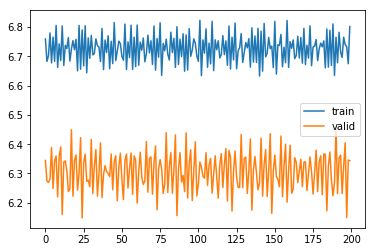

In [52]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train", "valid"])

In [11]:
num_cnn_layers = 5
num_lstm_layers = 2
num_lin_layers = 2
inputLayer = tf.keras.layers.Input((1500, 3))
x = inputLayer


for i in range(num_cnn_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(10, (3,), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool1D((2,))(x)
for j in range(num_lstm_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.CuDNNLSTM(512, return_sequences=True)(x)
    x = tf.keras.layers.LeakyReLU()(x)


x = tf.keras.layers.Flatten(name="flatten_encoder_lstm")(x)


x_shared_flattened = x

#one_off
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(1)(x)
x_on_off = tf.keras.layers.ReLU(name="on_off", max_value=4)(x)

#tremor
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(1)(x)
x_dyskinesia = tf.keras.layers.ReLU(name="dyskinesia", max_value=4)(x)

#montage classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(1)(x)
x_tremor = tf.keras.layers.ReLU(name="tremor", max_value=4)(x)



model = tf.keras.Model(inputs=inputLayer, outputs=[x_on_off, x_dyskinesia, x_tremor])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
model.compile("adam", loss=["mean_squared_error", "mean_squared_error", "mean_squared_error" ])
model.summary()

Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1500, 3)      0                                            
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 1500, 3)      12          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1500, 10)     100         batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 1500, 10)     0           conv1d[0][0]                     
_____________________________________________________________

In [ ]:
#about 200k examples, so go with 200k/64 for train

In [13]:
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/cnnlstm1.h5", save_best_only=True, verbose=True)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(patience=10, verbose=True)
earlyStopping = tf.keras.callbacks.EarlyStopping(patience=25, verbose=True)
train_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/all_data.tfr", m_ids=train_indices, batch_size=128)
valid_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/all_data.tfr", m_ids=valid_indices, batch_size=128)
test_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/all_data.tfr", m_ids=test_indices, batch_size=128)

history = model.fit(train_data, steps_per_epoch=1000, epochs=100, validation_data=valid_data, validation_steps=200, callbacks=[modelCheckpoint, reduceLR, earlyStopping])

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 999/1000 [============================>.] - ETA: 0s - loss: 6.9212 - on_off_loss: 3.2671 - dyskinesia_loss: 1.5599 - tremor_loss: 2.0942
Epoch 00001: val_loss improved from inf to 6.88719, saving model to /n/scratch2/ms994/cnnlstm1.h5
1000/1000 [==============================] - 113s 113ms/step - loss: 6.9216 - on_off_loss: 3.2676 - dyskinesia_loss: 1.5596 - tremor_loss: 2.0944 - val_loss: 6.8872 - val_on_off_loss: 3.5847 - val_dyskinesia_loss: 1.3165 - val_tremor_loss: 1.9860
Epoch 2/100
 999/1000 [============================>.] - ETA: 0s - loss: 6.9237 - on_off_loss: 3.2695 - dyskinesia_loss: 1.5577 - tremor_loss: 2.0965
Epoch 00002: val_loss improved from 6.88719 to 6.87512, saving model to /n/scratch2/ms994/cnnlstm1.h5
1000/1000 [==============================] - 105s 105ms/step - loss: 6.9229 - on_off_loss: 3.2688 - dyskinesia_loss: 1.5577 - tremor_loss: 2.0964 - val_loss: 6.8751 - val_on_off_loss: 3.5992 - val_dyskines

 999/1000 [============================>.] - ETA: 0s - loss: 6.9302 - on_off_loss: 3.2713 - dyskinesia_loss: 1.5608 - tremor_loss: 2.0981
Epoch 00018: val_loss improved from 6.86906 to 6.86609, saving model to /n/scratch2/ms994/cnnlstm1.h5
1000/1000 [==============================] - 105s 105ms/step - loss: 6.9299 - on_off_loss: 3.2712 - dyskinesia_loss: 1.5608 - tremor_loss: 2.0979 - val_loss: 6.8661 - val_on_off_loss: 3.5762 - val_dyskinesia_loss: 1.3055 - val_tremor_loss: 1.9844
Epoch 19/100
 999/1000 [============================>.] - ETA: 0s - loss: 6.9231 - on_off_loss: 3.2687 - dyskinesia_loss: 1.5576 - tremor_loss: 2.0968
Epoch 00019: val_loss did not improve from 6.86609
1000/1000 [==============================] - 104s 104ms/step - loss: 6.9224 - on_off_loss: 3.2684 - dyskinesia_loss: 1.5574 - tremor_loss: 2.0967 - val_loss: 6.8948 - val_on_off_loss: 3.6018 - val_dyskinesia_loss: 1.3152 - val_tremor_loss: 1.9778
Epoch 20/100
 999/1000 [============================>.] - ETA: 0

 999/1000 [============================>.] - ETA: 0s - loss: 6.9300 - on_off_loss: 3.2721 - dyskinesia_loss: 1.5605 - tremor_loss: 2.0974
Epoch 00036: val_loss did not improve from 6.85777
1000/1000 [==============================] - 104s 104ms/step - loss: 6.9303 - on_off_loss: 3.2724 - dyskinesia_loss: 1.5605 - tremor_loss: 2.0975 - val_loss: 6.8990 - val_on_off_loss: 3.5886 - val_dyskinesia_loss: 1.3192 - val_tremor_loss: 1.9912
Epoch 37/100
 999/1000 [============================>.] - ETA: 0s - loss: 6.9245 - on_off_loss: 3.2738 - dyskinesia_loss: 1.5578 - tremor_loss: 2.0929
Epoch 00037: val_loss did not improve from 6.85777

Epoch 00037: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1000/1000 [==============================] - 104s 104ms/step - loss: 6.9246 - on_off_loss: 3.2741 - dyskinesia_loss: 1.5579 - tremor_loss: 2.0926 - val_loss: 6.8778 - val_on_off_loss: 3.5959 - val_dyskinesia_loss: 1.3039 - val_tremor_loss: 1.9780
Epoch 38/100
 999/1000 [=========

Epoch 54/100
 999/1000 [============================>.] - ETA: 0s - loss: 6.9207 - on_off_loss: 3.2709 - dyskinesia_loss: 1.5572 - tremor_loss: 2.0926
Epoch 00054: val_loss did not improve from 6.85441
1000/1000 [==============================] - 105s 105ms/step - loss: 6.9209 - on_off_loss: 3.2707 - dyskinesia_loss: 1.5574 - tremor_loss: 2.0929 - val_loss: 6.8849 - val_on_off_loss: 3.5872 - val_dyskinesia_loss: 1.3135 - val_tremor_loss: 1.9842
Epoch 55/100
 999/1000 [============================>.] - ETA: 0s - loss: 6.9211 - on_off_loss: 3.2698 - dyskinesia_loss: 1.5557 - tremor_loss: 2.0956
Epoch 00055: val_loss did not improve from 6.85441
1000/1000 [==============================] - 104s 104ms/step - loss: 6.9213 - on_off_loss: 3.2700 - dyskinesia_loss: 1.5557 - tremor_loss: 2.0956 - val_loss: 6.8833 - val_on_off_loss: 3.6021 - val_dyskinesia_loss: 1.3053 - val_tremor_loss: 1.9759
Epoch 56/100
 999/1000 [============================>.] - ETA: 0s - loss: 6.9391 - on_off_loss: 3.2786

In [14]:
import pickle as pkl
pkl.dump(history.history, open("history2.pkl", "wb"))

In [22]:
model = tf.keras.models.load_model("/n/scratch2/ms994/cnnlstm1.h5")

In [23]:
model.evaluate(test_data, steps=300)

300/300 [==============================] - 24s 81ms/step - loss: 6.1137 - on_off_loss: 3.0089 - dyskinesia_loss: 1.2926 - tremor_loss: 1.8122


[6.11375, 3.0089324, 1.2926302, 1.8121876]

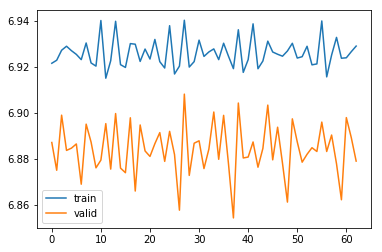

In [24]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train", "valid"])

In [64]:
%%bash
scancel 3009160